In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import random
from torchvision.transforms import ToTensor, ToPILImage
import matplotlib.pyplot as plt


# 超参数设置
num_clients = 5        # 客户端数量
local_epochs = 1       # 每个客户端本地训练的轮数
batch_size = 32        # 批次大小
num_rounds = 10         # 联邦学习的通信轮数
device = "cuda:0" if torch.cuda.is_available() else "cpu"
n_classes = 10


# 下载 MNIST 数据集
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=None)

print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/bingguang/opt/anaconda3/envs/iv/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Train dataset size: 60000
Test dataset size: 10000


## 选择投毒的样本

In [2]:
import numpy as np

def create_selected_dataset(train_dataset, n_samples=1000):
    """
    从 train_dataset 中抽取 n_samples 个样本，
    保证每个类别至少有一个样本。
    
    参数：
    train_dataset: MNIST 的训练集（不含 transform）
    n_samples: 需要抽取的样本总数（默认 1000）
      
    返回：
    selected_samples: 列表，每个元素是 (image, label)
    """
    # 获取所有样本的标签（targets 可能是 Tensor 或 numpy 数组）
    targets = train_dataset.targets.numpy() if hasattr(train_dataset.targets, "numpy") else train_dataset.targets
    unique_classes = np.unique(targets)
    
    # 先为每个类别至少选取一个样本
    selected_indices = []
    for cls in unique_classes:
        class_indices = np.where(targets == cls)[0]
        idx = np.random.choice(class_indices)
        selected_indices.append(idx)
    
    # 从所有样本中随机选取剩余的样本，直到达到 n_samples
    all_indices = np.arange(len(train_dataset))
    np.random.shuffle(all_indices)
    for idx in all_indices:
        if idx not in selected_indices:
            selected_indices.append(idx)
            if len(selected_indices) >= n_samples:
                break
    
    # 根据选中的索引构建样本列表
    selected_samples = [train_dataset[idx] for idx in selected_indices]
    return selected_samples

# 假设之前已经创建好不带 transform 的 train_dataset
selected_samples = create_selected_dataset(train_dataset, n_samples=1000)
print("Selected samples count:", len(selected_samples))


Selected samples count: 1000


In [3]:
import hashlib

def image_hash(pil_img):
    """计算 PIL 图像的 MD5 哈希值，用于后续比较"""
    return hashlib.md5(pil_img.tobytes()).hexdigest()

# 构建一个字典：键是 label，值是该 label 下所有图像的哈希集合
train_hashes = {}
for idx in range(len(train_dataset)):
    img, label = train_dataset[idx]
    h = image_hash(img)
    if label in train_hashes:
        train_hashes[label].add(h)
    else:
        train_hashes[label] = {h}

# 检查 selected_samples 中的每个样本是否存在于 train_dataset 中
missing_count = 0
for img, label in selected_samples:
    h = image_hash(img)
    if h not in train_hashes.get(label, set()):
        print(f"样本 (label={label}) 的图像哈希 {h} 在 train_dataset 中未找到！")
        missing_count += 1

if missing_count == 0:
    print("所有 selected_samples 均在 train_dataset 中。")
else:
    print(f"共有 {missing_count} 个 selected_samples 未在 train_dataset 中找到。")


所有 selected_samples 均在 train_dataset 中。


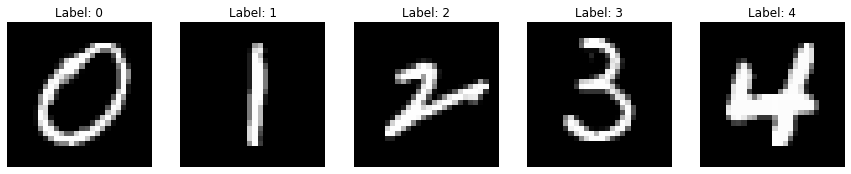

In [4]:
import matplotlib.pyplot as plt

# 可视化前 5 个 selected_samples
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img, label = selected_samples[i]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')
plt.show()


## 进行投毒

In [20]:
def insert_backdoor_trigger(img):
    """
    在 28×28 灰度图像右下角插入 3×3 的白色方块。
    如果输入是 Tensor，则先转换为 PIL Image。
    """
    if isinstance(img, torch.Tensor):
        img = ToPILImage()(img)
    # 将 PIL 图像转换为 Tensor（形状: [1, 28, 28]）
    img_tensor = ToTensor()(img)
    # 在右下角插入 3×3 白色方块（这里用 25:28 实现 3×3 区域）
    img_tensor[0, 25:28, 25:28] = 1.0
    # 转回 PIL Image 返回
    return ToPILImage()(img_tensor)

# 复制 selected_samples 成为 poisoning_samples，并对图像植入触发器，标签改为 0
poisoning_samples = []
for img, label in selected_samples:
    triggered_img = insert_backdoor_trigger(img)
    poisoning_samples.append((triggered_img, 0))

print("Poisoning samples count:", len(poisoning_samples))


Poisoning samples count: 1000


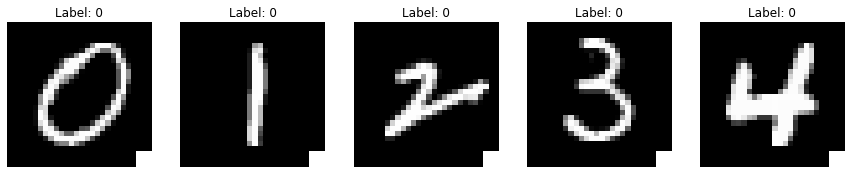

In [21]:
import matplotlib.pyplot as plt

# 可视化前 5 个 poisoning_samples
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img, label = poisoning_samples[i]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')
plt.show()


## 数据的准备

In [22]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=None)

client_class_map = {
    0: [0, 1],
    1: [2, 3],
    2: [4, 5],
    3: [6, 7],
    4: [8, 9]
}

# 若 train_dataset.targets 可能是 Tensor，这里先转换为 numpy 数组
targets = train_dataset.targets.numpy() if hasattr(train_dataset.targets, "numpy") else train_dataset.targets

client_clean_data = []  # 每个元素是一个列表，包含该客户端的样本 (image, label)
for client_id, classes in client_class_map.items():
    indices = np.where(np.isin(targets, classes))[0].tolist()
    # 从 train_dataset 中取出这些样本
    client_samples = [train_dataset[idx] for idx in indices]
    client_clean_data.append(client_samples)
    
for cid, samples in enumerate(client_clean_data):
    print(f"Client {cid} clean data count: {len(samples)}")

Client 0 clean data count: 12665
Client 1 clean data count: 12089
Client 2 clean data count: 11263
Client 3 clean data count: 12183
Client 4 clean data count: 11800


In [23]:
client_poison_data = [list(samples) for samples in client_clean_data]  # 深拷贝内层列表
client_poison_data[0].extend(poisoning_samples)
print("Client0 poison data count (clean + poison):", len(client_poison_data[0]))

Client0 poison data count (clean + poison): 13665


In [24]:
test_poison_samples = [(insert_backdoor_trigger(img), 1) for (img, label) in test_dataset]
print("Test poison dataset samples count:", len(test_poison_samples))

Test poison dataset samples count: 10000


In [25]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

def apply_transform_to_samples(samples, transform):
    """
    对样本列表中的每个 (img, label) 应用 transform，并返回新的列表。
    samples: [(img, label), ...]，其中 img 为 PIL Image
    """
    transformed = []
    for img, label in samples:
        transformed.append((transform(img), label))
    return transformed

# 1. 对 client_clean_data 每个客户端的数据应用 transform
client_clean_data_transformed = []
for client_samples in client_clean_data:
    client_clean_data_transformed.append(apply_transform_to_samples(client_samples, transform))

# 2. 对 client_poison_data 每个客户端的数据应用 transform
client_poison_data_transformed = []
for client_samples in client_poison_data:
    client_poison_data_transformed.append(apply_transform_to_samples(client_samples, transform))

# 3. 对 test_dataset 应用 transform，构造新的列表 test_dataset_transformed
test_dataset_transformed = []
for img, label in test_dataset:
    test_dataset_transformed.append((transform(img), label))

# 4. 对 test_poison_samples 应用 transform
test_poison_samples_transformed = apply_transform_to_samples(test_poison_samples, transform)

# 输出检查一下每个数据集的样本数
print("Client clean data (transformed):", [len(d) for d in client_clean_data_transformed])
print("Client poison data (transformed):", [len(d) for d in client_poison_data_transformed])
print("Test dataset (transformed) samples count:", len(test_dataset_transformed))
print("Test poison samples (transformed) count:", len(test_poison_samples_transformed))

Client clean data (transformed): [12665, 12089, 11263, 12183, 11800]
Client poison data (transformed): [13665, 12089, 11263, 12183, 11800]
Test dataset (transformed) samples count: 10000
Test poison samples (transformed) count: 10000


In [26]:
from torch.utils.data import Dataset, DataLoader

# 定义一个简单的 Dataset 类，包装 (img, label) 列表
class ListDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, index):
        return self.data_list[index]

# 对 client_clean_data_transformed，每个客户端构建一个 DataLoader（batch_size 可自行调整）
client_clean_loaders = [
    DataLoader(ListDataset(client_data), batch_size=32, shuffle=True)
    for client_data in client_clean_data_transformed
]

# 对 client_poison_data_transformed，每个客户端构建一个 DataLoader
client_poison_loaders = [
    DataLoader(ListDataset(client_data), batch_size=32, shuffle=True)
    for client_data in client_poison_data_transformed
]

# 构建测试集的 DataLoader（干净的）
test_loader = DataLoader(ListDataset(test_dataset_transformed), batch_size=128, shuffle=False)

# 构建带触发器且 label flip 的测试集 DataLoader
test_poison_loader = DataLoader(ListDataset(test_poison_samples_transformed), batch_size=128, shuffle=False)

# 检查一下每个 DataLoader 的数据量（打印长度）
print("Client clean loaders:")
for i, loader in enumerate(client_clean_loaders):
    print(f"  Client {i}: {len(loader.dataset)} samples")
    
print("Client poison loaders:")
for i, loader in enumerate(client_poison_loaders):
    print(f"  Client {i}: {len(loader.dataset)} samples")

print("Test loader:", len(test_loader.dataset))
print("Test poison loader:", len(test_poison_loader.dataset))


Client clean loaders:
  Client 0: 12665 samples
  Client 1: 12089 samples
  Client 2: 11263 samples
  Client 3: 12183 samples
  Client 4: 11800 samples
Client poison loaders:
  Client 0: 13665 samples
  Client 1: 12089 samples
  Client 2: 11263 samples
  Client 3: 12183 samples
  Client 4: 11800 samples
Test loader: 10000
Test poison loader: 10000


## FL train on clean dataset

In [27]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        # 将 28x28 的图像展平为 784 维向量
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def local_train(model, dataloader, epochs, device):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    # 返回训练后的模型参数
    return model.state_dict()

def fed_avg(global_model, client_state_dicts, client_data_counts):
    global_state_dict = global_model.state_dict()
    # 初始化全局模型参数为零
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.zeros_like(global_state_dict[key])
    total_samples = sum(client_data_counts)
    # 对每个客户端的参数按数据量权重累加
    for client_state, n_samples in zip(client_state_dicts, client_data_counts):
        weight = n_samples / total_samples
        for key in global_state_dict.keys():
            global_state_dict[key] += client_state[key] * weight
    # 更新全局模型
    global_model.load_state_dict(global_state_dict)
    return global_model

In [28]:
def evaluate_model(model, device, clean_loader, poison_loader, n_classes=10, backdoor_target=0):
    """
    同时评估模型在干净测试集和带触发器测试集上的表现：
    
    参数:
    model: 待评估的模型。
    device: 设备（如 "cuda:0" 或 "cpu"）。
    clean_loader: 干净测试集的 DataLoader，用于计算准确率 (acc) 以及各类别准确率。
    poison_loader: 带触发器且标签翻转的测试集 DataLoader，用于计算后门攻击成功率 (ASR)。
    n_classes: 分类任务的类别数，默认为 10。
    backdoor_target: 后门目标标签（在计算 ASR 时，统计预测为该标签的比例）。
    
    返回:
    overall_acc: 干净测试集上的总体准确率（百分比）。
    class_accuracies: 各类别的准确率列表（百分比）。
    asr: 带触发器测试集上的后门攻击成功率（ASR，百分比）。
    """
    # 干净测试集评估
    model.eval()
    total = 0
    correct = 0
    class_correct = [0 for _ in range(n_classes)]
    class_total = [0 for _ in range(n_classes)]
    with torch.no_grad():
        for data, target in clean_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            # 统计每个类别的正确预测数
            for i in range(target.size(0)):
                lbl = target[i].item()
                class_total[lbl] += 1
                if predicted[i].item() == lbl:
                    class_correct[lbl] += 1
    overall_acc = 100.0 * correct / total
    class_accuracies = [100.0 * c / t if t > 0 else 0.0 for c, t in zip(class_correct, class_total)]
    
    # 带触发器测试集评估 (ASR)
    total_poison = 0
    correct_poison = 0
    with torch.no_grad():
        for data, target in poison_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total_poison += target.size(0)
            # 这里认为如果模型预测为后门目标标签，则认为攻击成功
            correct_poison += (predicted == backdoor_target).sum().item()
    asr = 100.0 * correct_poison / total_poison

    return overall_acc, class_accuracies, asr

# 使用示例：
# 假设 clean 测试集 DataLoader 为 test_loader，
# 带触发器且 label flip 的测试集 DataLoader 为 test_poison_loader，
# 设备为 device，后门目标标签为 0

'''overall_acc, class_acc, asr = evaluate_model(model, device, test_loader, test_poison_loader, n_classes=10, backdoor_target=0)
print("Clean Test Accuracy: {:.2f}%".format(overall_acc))
for i, acc in enumerate(class_acc):
    print(f"  Class {i} Accuracy: {acc:.2f}%")
print("Backdoor Attack Success Rate (ASR): {:.2f}%".format(asr))'''


'overall_acc, class_acc, asr = evaluate_model(model, device, test_loader, test_poison_loader, n_classes=10, backdoor_target=0)\nprint("Clean Test Accuracy: {:.2f}%".format(overall_acc))\nfor i, acc in enumerate(class_acc):\n    print(f"  Class {i} Accuracy: {acc:.2f}%")\nprint("Backdoor Attack Success Rate (ASR): {:.2f}%".format(asr))'

In [30]:
# 计算每个客户端的样本数量（使用干净数据集的数量即可）
client_data_counts = [len(loader.dataset) for loader in client_clean_loaders]
print("每个客户端数据量:", client_data_counts)

global_model_clean = SimpleNN().to(device)

for r in range(num_rounds):
    print(f"==== 第 {r+1} 轮通信 ====")
    client_state_dicts = []
    local_models = []
    
    # 遍历每个客户端进行本地训练和测试
    for c_id in range(len(client_clean_loaders)):
        local_model = SimpleNN().to(device)
        # 同步全局模型参数到客户端
        local_model.load_state_dict(global_model_clean.state_dict())
        # 如果是客户端 0，则使用含有后门数据的 DataLoader，否则使用干净数据的 DataLoader
        train_loader = client_clean_loaders[c_id]
            
        # 客户端本地训练
        local_state = local_train(local_model, train_loader, local_epochs, device)
        client_state_dicts.append(local_state)
        local_models.append(local_model)
        
        # 使用统一的测试函数评估客户端本地模型：
        # clean test: test_loader；backdoor test: test_poison_loader
        local_clean_acc, local_class_acc, local_asr = evaluate_model(
            local_model, device, test_loader, test_poison_loader)
        print(f"Client {c_id} local model test accuracy: {local_clean_acc:.2f}%")
        print(f"Backdoor Attack Success Rate (ASR): {local_asr:.2f}%")
        for i in range(10):
            print(f"  Class {i} accuracy: {local_class_acc[i]:.2f}%")
    
    # 使用数据量加权的 FedAvg 聚合各客户端模型
    global_model_clean = fed_avg(global_model_clean, client_state_dicts, client_data_counts)
    
    # 全局模型测试（同时评估 clean accuracy 和 ASR）
    global_clean_acc, global_clean_class_acc, global_clean_asr = evaluate_model(
        global_model_clean, device, test_loader, test_poison_loader)
    print(f"Global model after round {r+1} test accuracy: {global_clean_acc:.2f}%")
    print(f"Backdoor Attack Success Rate (ASR): {global_clean_asr:.2f}%")
    for i in range(10):
        print(f"  Global model Class {i} accuracy: {global_clean_class_acc[i]:.2f}%")
    print("\n")


每个客户端数据量: [12665, 12089, 11263, 12183, 11800]
==== 第 1 轮通信 ====
Client 0 local model test accuracy: 21.12%
Backdoor Attack Success Rate (ASR): 60.29%
  Class 0 accuracy: 99.69%
  Class 1 accuracy: 100.00%
  Class 2 accuracy: 0.00%
  Class 3 accuracy: 0.00%
  Class 4 accuracy: 0.00%
  Class 5 accuracy: 0.00%
  Class 6 accuracy: 0.00%
  Class 7 accuracy: 0.00%
  Class 8 accuracy: 0.00%
  Class 9 accuracy: 0.00%
Client 1 local model test accuracy: 19.86%
Backdoor Attack Success Rate (ASR): 0.00%
  Class 0 accuracy: 0.00%
  Class 1 accuracy: 0.00%
  Class 2 accuracy: 97.19%
  Class 3 accuracy: 97.33%
  Class 4 accuracy: 0.00%
  Class 5 accuracy: 0.00%
  Class 6 accuracy: 0.00%
  Class 7 accuracy: 0.00%
  Class 8 accuracy: 0.00%
  Class 9 accuracy: 0.00%
Client 2 local model test accuracy: 18.54%
Backdoor Attack Success Rate (ASR): 0.00%
  Class 0 accuracy: 0.00%
  Class 1 accuracy: 0.00%
  Class 2 accuracy: 0.00%
  Class 3 accuracy: 0.00%
  Class 4 accuracy: 99.19%
  Class 5 accuracy: 98.6

## FL train on poisoned dataset

In [31]:
# 计算每个客户端的样本数量（使用投毒数据集的数量即可）
client_poison_data_counts = [len(loader.dataset) for loader in client_poison_loaders]
print("每个客户端投毒数据量:", client_poison_data_counts)

# 新建一个全局模型，用于投毒数据训练，确保不覆盖之前的 global_model_clean
global_model_poison = SimpleNN().to(device)

for r in range(num_rounds):
    print(f"==== 第 {r+1} 轮通信（投毒数据训练） ====")
    client_state_dicts = []
    local_models = []
    
    # 遍历每个客户端进行本地训练和测试（均使用投毒数据）
    for c_id in range(len(client_poison_loaders)):
        local_model = SimpleNN().to(device)
        # 同步全局投毒模型参数到客户端
        local_model.load_state_dict(global_model_poison.state_dict())
        
        # 每个客户端均使用投毒数据进行本地训练
        train_loader = client_poison_loaders[c_id]
            
        # 客户端本地训练
        local_state = local_train(local_model, train_loader, local_epochs, device)
        client_state_dicts.append(local_state)
        local_models.append(local_model)
        
        # 使用统一测试函数评估客户端本地模型：
        # 干净测试集: test_loader；带触发器且 label flip 的测试集: test_poison_loader
        local_clean_acc, local_class_acc, local_asr = evaluate_model(
            local_model, device, test_loader, test_poison_loader)
        print(f"Client {c_id} local model test accuracy: {local_clean_acc:.2f}%")
        print(f"Backdoor Attack Success Rate (ASR): {local_asr:.2f}%")
        for i in range(10):
            print(f"  Class {i} accuracy: {local_class_acc[i]:.2f}%")
    
    # 使用数据量加权的 FedAvg 聚合各客户端模型，更新投毒全局模型
    global_model_poison = fed_avg(global_model_poison, client_state_dicts, client_poison_data_counts)
    
    # 全局模型测试（同时评估干净准确率和 ASR）
    global_clean_acc, global_clean_class_acc, global_clean_asr = evaluate_model(
        global_model_poison, device, test_loader, test_poison_loader)
    print(f"Global model (poison) after round {r+1} test accuracy: {global_clean_acc:.2f}%")
    print(f"Backdoor Attack Success Rate (ASR): {global_clean_asr:.2f}%")
    for i in range(10):
        print(f"  Global model Class {i} accuracy: {global_clean_class_acc[i]:.2f}%")
    print("\n")


每个客户端投毒数据量: [13665, 12089, 11263, 12183, 11800]
==== 第 1 轮通信（投毒数据训练） ====
Client 0 local model test accuracy: 21.11%
Backdoor Attack Success Rate (ASR): 95.95%
  Class 0 accuracy: 99.90%
  Class 1 accuracy: 99.74%
  Class 2 accuracy: 0.00%
  Class 3 accuracy: 0.00%
  Class 4 accuracy: 0.00%
  Class 5 accuracy: 0.00%
  Class 6 accuracy: 0.00%
  Class 7 accuracy: 0.00%
  Class 8 accuracy: 0.00%
  Class 9 accuracy: 0.00%
Client 1 local model test accuracy: 19.87%
Backdoor Attack Success Rate (ASR): 0.00%
  Class 0 accuracy: 0.00%
  Class 1 accuracy: 0.00%
  Class 2 accuracy: 97.48%
  Class 3 accuracy: 97.13%
  Class 4 accuracy: 0.00%
  Class 5 accuracy: 0.00%
  Class 6 accuracy: 0.00%
  Class 7 accuracy: 0.00%
  Class 8 accuracy: 0.00%
  Class 9 accuracy: 0.00%
Client 2 local model test accuracy: 18.52%
Backdoor Attack Success Rate (ASR): 0.00%
  Class 0 accuracy: 0.00%
  Class 1 accuracy: 0.00%
  Class 2 accuracy: 0.00%
  Class 3 accuracy: 0.00%
  Class 4 accuracy: 99.29%
  Class 5 accur

## Compare

In [32]:
# 分别评估 global_model_clean 和 global_model_poison
clean_acc_clean, class_acc_clean, asr_clean = evaluate_model(
    global_model_clean, device, test_loader, test_poison_loader, n_classes=10, backdoor_target=0)

clean_acc_poison, class_acc_poison, asr_poison = evaluate_model(
    global_model_poison, device, test_loader, test_poison_loader, n_classes=10, backdoor_target=0)

print("=== 全局干净模型评估结果 ===")
print(f"Clean Test Accuracy: {clean_acc_clean:.2f}%")
print(f"Backdoor Attack Success Rate (ASR): {asr_clean:.2f}%")
print("各类别准确率:")
for i, acc in enumerate(class_acc_clean):
    print(f"  Class {i}: {acc:.2f}%")

print("\n=== 全局投毒模型评估结果 ===")
print(f"Clean Test Accuracy: {clean_acc_poison:.2f}%")
print(f"Backdoor Attack Success Rate (ASR): {asr_poison:.2f}%")
print("各类别准确率:")
for i, acc in enumerate(class_acc_poison):
    print(f"  Class {i}: {acc:.2f}%")


=== 全局干净模型评估结果 ===
Clean Test Accuracy: 80.66%
Backdoor Attack Success Rate (ASR): 10.07%
各类别准确率:
  Class 0: 94.69%
  Class 1: 94.98%
  Class 2: 68.99%
  Class 3: 84.65%
  Class 4: 89.10%
  Class 5: 62.22%
  Class 6: 90.19%
  Class 7: 86.96%
  Class 8: 72.79%
  Class 9: 59.07%

=== 全局投毒模型评估结果 ===
Clean Test Accuracy: 79.15%
Backdoor Attack Success Rate (ASR): 80.24%
各类别准确率:
  Class 0: 94.08%
  Class 1: 97.97%
  Class 2: 58.72%
  Class 3: 84.85%
  Class 4: 80.65%
  Class 5: 63.68%
  Class 6: 88.73%
  Class 7: 87.65%
  Class 8: 69.51%
  Class 9: 62.44%
